In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from scipy.special import expit
from mobilenet import mobilenet_v1
from preprocessing import preprocessing_factory
from scipy.ndimage import imread
preprocessing = preprocessing_factory.get_preprocessing('mobilenet_v1')
CLASS_OF_INTEREST = 10
EPS = 0.1
sess = tf.Session()

## Get some pretrained tensorflow network for our needs

10 класс это страус.

11 класс это птичка.


$y = f(x)$, where y - prediction, $f(\cdot)$ - NN, x - image(for example)

In [2]:
arr = imread('./brambling.jpg')
img = preprocessing(tf.Variable(arr, dtype=tf.float32) / 255, output_height=224, output_width=224)

/home/acappello/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':


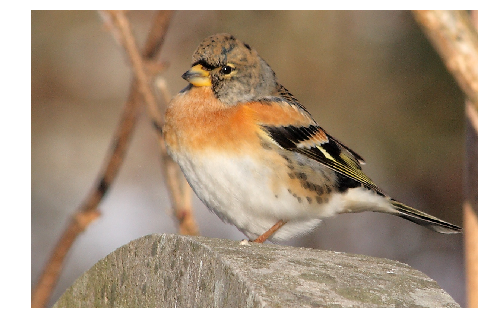

In [3]:
plt.imshow(arr);
plt.axis('off')
plt.show();

Инициализируем переменные, которые нам понадобятся.

Сейчас инициализируем картинкой птички.

In [4]:
D = 224 * 224 * 3
# theta = tf.Variable(tf.random_uniform([224, 224, 3], minval=0.1, maxval=0.9), name="theta") # noise init
theta = tf.Variable(img, name="theta") # bird init
mu = [0.] * D
diag_stdev = [.02] * D
p_dist = tf.contrib.distributions.MultivariateNormalDiag(mu, diag_stdev)
p = tf.Variable(tf.reshape(p_dist.sample(), [224, 224, 3]), name="p")

Загружаем веса сетки

In [5]:
with tf.contrib.slim.arg_scope(mobilenet_v1.mobilenet_v1_arg_scope()):
    logits, net = mobilenet_v1.mobilenet_v1(tf.expand_dims(theta, axis=0), is_training=False, num_classes=1001)
    
init_fn = tf.contrib.slim.assign_from_checkpoint_fn('./mobilenet/mobilenet_v1_1.0_224.ckpt', 
                                                        tf.contrib.slim.get_model_variables())

In [6]:
theta_old = tf.Variable(tf.zeros([224, 224, 3]), name="theta_old")
p_old = tf.Variable(tf.zeros([224, 224, 3]), name="p_old")

$log\_joint$ -- нечто вроде $\log(p)$

In [7]:
classifier = tf.sigmoid(logits)[:, CLASS_OF_INTEREST][0]
#log_joint = 10 * (classifier - 1 + EPS)
log_joint = logits[:, CLASS_OF_INTEREST][0]
#dist = tf.contrib.distributions.Normal(tf.zeros_like(theta), tf.ones_like(theta))
#log_joint = tf.reduce_mean(tf.log(dist.prob(theta)))
# p(x) ~ exp(10 * (y - 1 + eps))
step = tf.constant(.5, name='step')
one = tf.constant(1.)
two = tf.constant(2.)

### Функция для шага алгоритма

In [8]:
def train_step(theta, p, p_old, theta_old, log_joint, L):
    assign_ops = []
    # calc H at the beginning
    H_old = tf.reduce_sum(log_joint) + tf.reduce_sum(p**2) / two

    # save old
    p_old_assigned = p_old.assign(p); assign_ops.append(p_old_assigned)
    theta_old_assigned = theta_old.assign(theta); assign_ops.append(theta_old_assigned)

    # draw impulse from normal distribution
    with tf.control_dependencies([H_old, p_old_assigned]):
        p_assigned = p.assign(tf.reshape(p_dist.sample(), [224, 224, 3])); assign_ops.append(p_assigned)
    
    # integration leap frog step
    with tf.control_dependencies([p_assigned]):
        p_assigned = p.assign_add(step * tf.gradients(log_joint, theta)[0] / two); assign_ops.append(p_assigned)
    
    for i in range(L):
        with tf.control_dependencies([p_assigned, theta_old_assigned]):
            assign_ops.append(tf.gradients(log_joint, theta)[0])
            theta_assigned = theta.assign(tf.clip_by_value(theta + step * p, -1, 1)); assign_ops.append(theta_assigned)
        if i != L - 1:
            with tf.control_dependencies([theta_assigned]):
                p_assigned = p.assign_add(step * tf.gradients(log_joint, theta)[0] / two); assign_ops.append(p_assigned)
            
    with tf.control_dependencies([theta_assigned]):
        assign_ops.append(tf.gradients(log_joint, theta)[0])
        p_assigned = p.assign_add(step * tf.gradients(log_joint, theta)[0] / two); assign_ops.append(p_assigned)
    
    # new H
    with tf.control_dependencies([p_assigned]):
        H_new = tf.reduce_sum(log_joint) + tf.reduce_sum(p**2) / two
    
    with tf.control_dependencies([p_old_assigned, theta_old_assigned, p_assigned]):
        alpha = tf.minimum(one, tf.exp(H_new - H_old))
        p_order = tf.random_uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
        pred = tf.less(p_order, alpha)
        assign_ops.append(p.assign(tf.cond(pred, lambda: p, lambda: p_old)))
        assign_ops.append(theta.assign(tf.cond(pred, lambda: theta, lambda: theta_old)))
    return assign_ops

In [9]:
train_step_op = train_step(log_joint=log_joint, theta=theta, p=p, p_old=p_old, theta_old=theta_old, L=1)

In [10]:
init = tf.global_variables_initializer()
init.run(session=sess)
init_fn(sess)

INFO:tensorflow:Restoring parameters from ./mobilenet/mobilenet_v1_1.0_224.ckpt


Проверяем вероятности. Всё хорошо, это действительно птичка(1.0 вероятность), а не страус(p=0.123).

In [11]:
print("Probability of class 10:", sess.run(classifier))

Probability of class 10: 0.123139


In [12]:
print("Probability of class 11:", expit(sess.run(logits)[0][11]))

Probability of class 11: 1.0


## Запускаем Монте-Карло на 10 итераций

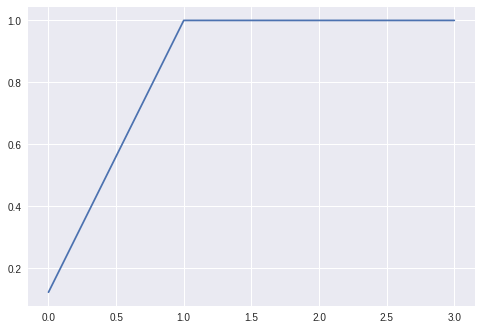

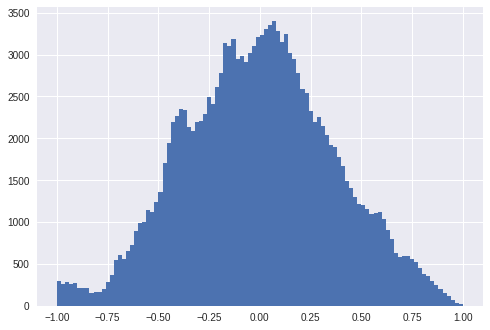

100%|██████████| 10/10 [00:07<00:00,  1.15it/s]


In [13]:
import tqdm
from IPython.display import clear_output
theta_samples = []
p_samples = []
H_samples = []
proba_samples = []
grad_sum_samples = []
N = 10


for i in tqdm.tqdm(range(N)):
    if i % 3 == 0:
        clear_output()
        proba_samples.append(
            sess.run(classifier)
        )
        plt.plot(proba_samples)
        plt.show()
        plt.hist(sess.run(theta).ravel(), bins=100);
        plt.show()
    sess.run(train_step_op)

### Теперь это и птичка и страус.

In [14]:
print(sess.run(logits)[0][CLASS_OF_INTEREST], sess.run(log_joint))
print("Probability of class 10:", sess.run(classifier))

18.9767 18.9767
Probability of class 10: 1.0


In [15]:
print("Probability of class 11:", expit(sess.run(logits)[0][11]))

Probability of class 11: 1.0


In [16]:
pic = sess.run(theta)
old_pic = sess.run(img)

### Различие картинок буквально в отдельных пикселях и его ещё нужно заметить!

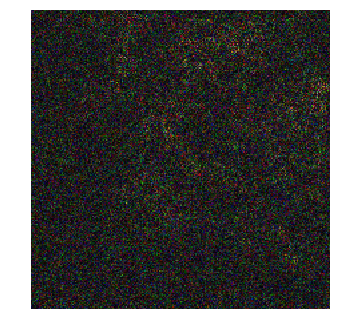

In [18]:
plt.imshow(10 * np.log(1 + np.abs(pic - old_pic)));
plt.axis('off')
plt.show()

Картинка после Монте-Карло

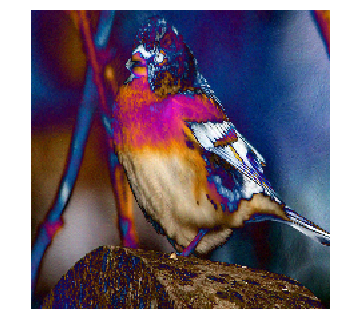

In [19]:
plt.imshow(np.abs(pic))
plt.axis('off')
plt.show()

Картинка до Монте-Карло

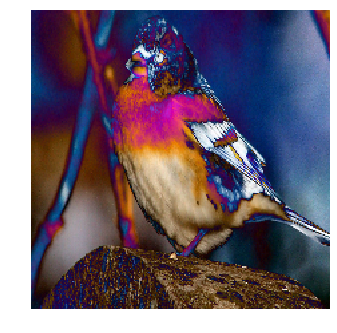

In [20]:
plt.imshow(np.abs(old_pic))
plt.axis('off')
plt.show()